The agent learns through trial and error by interacting with the environment and receiving rewards for its actions.

## Import necessary libraries

In [1]:
!pip install tensorflow==2.8.0rc0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.8/952.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-

In [7]:
import tensorflow as tf
if not tf.config.list_physical_devices('GPU'):  # Check for GPU availability
  print("Installing TensorFlow for GPU support...")
  !pip install tensorflow-gpu  # Install TensorFlow with GPU support
else:
  print("TensorFlow is already installed with GPU support.")

Installing TensorFlow for GPU support...
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-based projects


In [8]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'

<ipython-input-8-eabaf03f8e47>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [9]:
import warnings as w
w.simplefilter('ignore')

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [11]:
import tensorflow as tf

In [12]:
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [13]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Set random seeds for reproducibility.

In [14]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)

# Improved Finance Environment

Define helper classes for the financial environment:

observation_space: Defines the state space (data points) the agent observes.

action_space: Defines the possible actions the agent can take (in this case, buy or sell).

Finance: This class creates a simulated financial environment based on historical data. It takes arguments like symbol (stock ticker), features to consider (e.g., price, volatility), window size for calculations, etc.

It prepares the data by calculating features like rolling mean, standard deviation, and converting prices to logarithmic returns.

In [15]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [16]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [17]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data['s'] = self.data[self.symbol].rolling(
                                              self.window).mean()
        self.data['m'] = self.data['r'].rolling(self.window).mean()
        self.data['v'] = self.data['r'].rolling(self.window).std()
        self.data.dropna(inplace=True)
        if self.mu is None:
            self.mu = self.data.mean()
            self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        self.data_['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data_['d'] = self.data_['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar-
                        self.lags:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data_['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_1 = 1 if correct else 0
        reward_2 = abs(ret) if correct else -abs(ret)
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == 1:
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 252, done, info

In [18]:
env = Finance('EUR=', ['EUR=', 'r', 'v'], window=10, lags=5)

In [19]:
a = env.action_space.sample()
a

0

In [20]:
env.reset()

array([[ 1.7721, -1.0214,  0.0351],
       [ 1.5973, -2.4432,  0.6954],
       [ 1.5876, -0.1208,  0.6   ],
       [ 1.6292,  0.6083,  0.6123],
       [ 1.6408,  0.1807,  0.3693]])

In [21]:
env.step(a)

(array([[ 1.5973, -2.4432,  0.6954],
        [ 1.5876, -0.1208,  0.6   ],
        [ 1.6292,  0.6083,  0.6123],
        [ 1.6408,  0.1807,  0.3693],
        [ 1.5725, -0.9502,  0.0035]]),
 2.3750521308536245,
 False,
 {})

# Improved Financial QL Agent

FQLAgent: This class defines the reinforcement learning agent. It takes the learning and validation environments, learning rate, and other hyperparameters.

It has methods for:

_build_model: This builds a neural network model that takes the state (past data points) as input and predicts the Q-values (estimated future rewards) for each action (buy or sell).

act: This function decides the action based on the current state. It uses epsilon-greedy exploration, where it randomly explores with some probability or chooses the action with the highest predicted Q-value.

replay: This function replays past experiences from memory to train the neural network model. It updates the Q-values based on the rewards received for taking actions in different states.

learn: This function trains the agent over a specified number of episodes. In each episode, the agent interacts with the environment, taking actions, collecting rewards, and updating its model through replay.

validate: This function evaluates the agent's performance on a separate validation environment after each training episode.

In [22]:
from collections import deque

In [32]:
class FQLAgent:
    def __init__(self, hidden_units, learning_rate, learn_env, valid_env, dropout=True):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.dropout = dropout
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        self.learning_rate = learning_rate
        self.gamma = 0.95
        self.batch_size = 128
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_units, learning_rate)
    def _build_model(self, hu, lr):
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
                        activation='relu'))
        if self.dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(hu, activation='relu'))
        if self.dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(2, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
        )
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state)[0, 0]
        return np.argmax(action)
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = \
                                self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                [1, self.learn_env.lags,
                                 self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                  av, self.max_treward), end='\r')
                    break
            self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
        print()
    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(10000):
            action = np.argmax(self.model.predict(state)[0, 0])
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % 20 == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | '
                    templ += 'eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break

This part sets the learning and validation environment parameters like symbol, features, window size, etc.

It creates instances of the Finance class for the learning and validation environments.

It sets a random seed for reproducibility and creates an FQLAgent instance.
It defines the number of training episodes.

Finally, it trains the agent using the learn method and plots the results (average rewards and performance) over time.

In [24]:
symbol = 'EUR='
features = ['r', 's', 'm', 'v']

In [25]:
a = 0
b = 2000
c = 500

In [33]:
learn_env = Finance(symbol, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=a, end=a + b, mu=None, std=None)

In [34]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2010-01-19 to 2017-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2000 non-null   float64
 1   r       2000 non-null   float64
 2   s       2000 non-null   float64
 3   m       2000 non-null   float64
 4   v       2000 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB


In [28]:
valid_env = Finance(symbol, features, window=learn_env.window,
                 lags=learn_env.lags, leverage=learn_env.leverage,
                 min_performance=learn_env.min_performance,
                 start=a + b, end=a + b + c,
                 mu=learn_env.mu, std=learn_env.std)

In [35]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2017-12-27 to 2019-12-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    500 non-null    float64
 1   r       500 non-null    float64
 2   s       500 non-null    float64
 3   m       500 non-null    float64
 4   v       500 non-null    float64
dtypes: float64(5)
memory usage: 23.4 KB


In [36]:
set_seeds(100)
agent = FQLAgent(48, 0.0001, learn_env, valid_env, True)

In [37]:
episodes = 61

In [38]:
%time agent.learn(episodes)

episode: 20/61 | VALIDATION | treward:  494 | perf: 0.933 | eps: 0.68
episode: 40/61 | VALIDATION | treward:  494 | perf: 0.918 | eps: 0.45
episode: 60/61 | VALIDATION | treward:  494 | perf: 0.918 | eps: 0.30

CPU times: user 2min 45s, sys: 5.12 s, total: 2min 50s
Wall time: 2min 42s


In [39]:
agent.epsilon

0.291602079838278

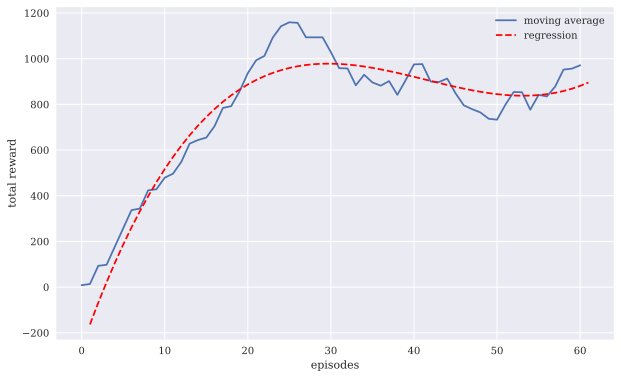

In [40]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

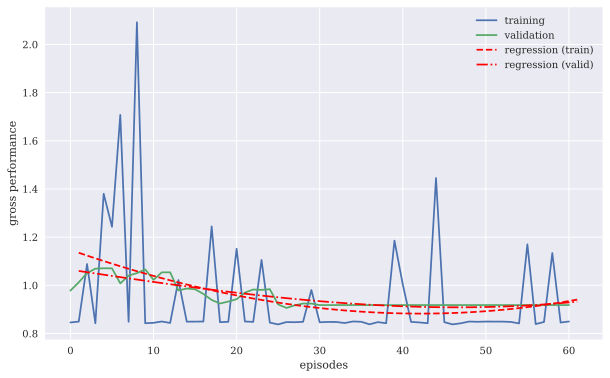

In [41]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.performances) + 1)
y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
plt.plot(agent.performances[:], label='training')
plt.plot(agent.vperformances[:], label='validation')
plt.plot(x, y, 'r--', label='regression (train)')
plt.plot(x, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend();